In [359]:
import numpy as np
from PIL import Image
from io import BytesIO
from IPython.display import display
import os
from google.cloud import vision
from tqdm.notebook import tqdm
import webcolors
import hashlib
import pymongo
import glob
import datetime
import decouple

config = decouple.AutoConfig(' ')
dir_from = 'imgs/origin/'
dir_archive = 'imgs/archive/'

In [227]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.abspath(os.path.join(os.getcwd(), 'config/sideb-proejct-0e33d8c0b0a9.json'))

In [228]:
mongo = pymongo.MongoClient(config('MONGODB_URI'))
db = mongo.Cluster0
colpix = db.pix

colpix.create_index('hash', unique=True)
colpix.create_index([('labels', 'text')])
colpix.index_information()

{'_id_': {'v': 2, 'key': [('_id', 1)]},
 'hash_1': {'v': 2, 'key': [('hash', 1)], 'unique': True},
 'labels_text': {'v': 2,
  'key': [('_fts', 'text'), ('_ftsx', 1)],
  'weights': SON([('labels', 1)]),
  'default_language': 'english',
  'language_override': 'language',
  'textIndexVersion': 3}}

In [372]:
class Pix:
    def __init__(self, imgpath):
        self.imgpath = imgpath
        self.client = vision.ImageAnnotatorClient()
        
        self.image = self.get_image()
        self.hash = self.hashing()
        
        self.resp_label = None
        self.resp_web = None
        self.resp_prop = None

        self.labels = None
        self.urls = None
        self.colors = None
        
        self.analyze()
        
        
    def get_image(self):
        with open(self.imgpath, 'rb') as img_file:
            content = img_file.read()

        return vision.Image(content=content)       
        
        
    def show(self):
        # display(Image.open(BytesIO(self.image.content)))
        display(Image.open(self.imgpath))

        
    def analyze(self):
        if colpix.find_one({'hash': self.hash}):
            print('이미 있네: ' + self.hash)
            return
        
        self.labels = self.annotate_label()
        self.urls = self.find_url()
        self.colors = self.extract_color()
        
        self.save_to_mongo()
        self.archive()
        
        
    def annotate_label(self, min_score=0.6):
        self.resp_label = self.client.label_detection(image=self.image, max_results=50)
        labels = self.resp_label.label_annotations
        labels = [label.description.lower().replace(' ', '_') for label in labels if label.score>=min_score]
        return ' '.join(labels)
        
        
    def find_url(self):
        try:
            self.resp_web = self.client.web_detection(image=self.image)
            
            if self.resp_web.web_detection.full_matching_images:
                return [img.url for img in self.resp_web.web_detection.full_matching_images]
            
            else:
                return [img.url for img in self.resp_web.web_detection.partial_matching_images]
        
        except:
            return []
        
        
    def extract_color(self, pct_thres=0.6):
        self.resp_props = self.client.image_properties(image=self.image)
        dom_colors = self.resp_props.image_properties_annotation.dominant_colors.colors

        pct_cum = 0
        colors = []
        score_sum = sum([clr.score for clr in dom_colors])

        # for clr in sorted(dom_colors, key=lambda x: -x.score): 
        # socore 기준 sort가 능사는 아니다. pixel_fraction도 중요하므로
        for clr in dom_colors:
            if pct_cum > pct_thres: 
                break

            pct_cum += (clr.score / score_sum)
            colors.append(self.get_color_name((clr.color.red, clr.color.green, clr.color.blue)))

        return ' '.join(colors)
        
        
    def hashing(self):
        _img = Image.open(self.imgpath).convert('RGB')
        _img_array = np.array(_img).astype(np.uint16)
        _img_bytes = _img_array.tobytes()
        return hashlib.sha256(_img_bytes).hexdigest()
        
        
    def closest_color(self, requested_color):
        min_colors = {}

        for key, name in webcolors.CSS21_HEX_TO_NAMES.items():
            r_c, g_c, b_c = webcolors.hex_to_rgb(key)
            rd = (r_c - requested_color[0]) ** 2
            gd = (g_c - requested_color[1]) ** 2
            bd = (b_c - requested_color[2]) ** 2
            min_colors[(rd + gd + bd)] = name

        return min_colors[min(min_colors.keys())]

    
    def get_color_name(self, requested_color):
        try:
            closest_name = webcolors.rgb_to_name(requested_color, spec='css21')

        except ValueError:
            closest_name = self.closest_color(requested_color)
            actual_name = None

        return closest_name
    
    
    def save_to_mongo(self):
        pix = {
            'labels': self.labels,
            'urls': self.urls,
            'colors': self.colors,
            'hash': self.hash,
            'created_at': datetime.datetime.utcnow()
        }
        return colpix.insert_one(pix).inserted_id
    
    
    def archive(self):
        ext = self.imgpath.split('.')[-1]
        imgpath_new = dir_archive + self.hash + '.' + ext
        os.rename(self.imgpath, imgpath_new)
        self.imgpath = imgpath_new

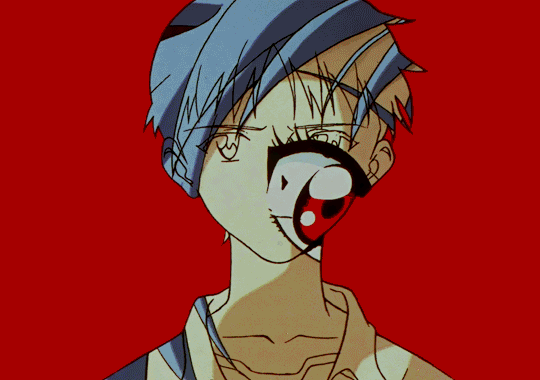

In [364]:
pix = Pix('imgs/origin/ray.gif')
pix.show()

In [365]:
pix.labels

'hair head hairstyle eye facial_expression mouth cartoon human_body gesture happy interaction art finger black_hair headgear font cg_artwork fictional_character illustration animated_cartoon graphics animation anime drawing fun fiction eyewear carmine magenta graphic_design'

In [366]:
pix.urls

['https://lookaside.fbsbx.com/lookaside/crawler/media/?media_id=1863142697264532',
 'https://www.latercera.com/resizer/W0POK4yGydaEpLLoDAlbvonZPlI=/900x600/smart/arc-anglerfish-arc2-prod-copesa.s3.amazonaws.com/public/EZG4UW3P6BFCDKT6SAHOZSYTIM.gif',
 'https://www.latercera.com/resizer/eRtm5DwKuVrh4FXWgFDwqhKHuko=/800x0/smart/arc-anglerfish-arc2-prod-copesa.s3.amazonaws.com/public/EZG4UW3P6BFCDKT6SAHOZSYTIM.gif',
 'https://p16-sign-va.tiktokcdn.com/tos-maliva-p-0068/558481384966447299a24f84917de004_1649650071~tplv-tiktokx-share-play.jpeg?x-expires=1655604000&x-signature=ucChW3cLeF0YNvXCHrTgjP1z8f0%3D',
 'https://res.cloudinary.com/jerrick/image/upload/f_jpg,q_auto,w_720/5e7d122eddce58001c543b83.gif',
 'https://sochi.scapp.ru/wp-content/uploads/post/2021/11/111890-2.gif',
 'https://i1.sndcdn.com/artworks-7d6y2TgkyirNh9nn-soVYUg-t500x500.jpg',
 'https://i1.sndcdn.com/avatars-000441112017-ge9q85-t500x500.jpg',
 'https://img.dmitory.com/img/202102/42I/gW0/42IgW0VdvaGUm8wM6EEKAC.gif',
 'htt

In [367]:
pix.hash

'6cf4902f0a6b70294ccf3e791d252b9c926b023106f401cf9bdb0d978d614462'

In [368]:
pix.colors

'silver maroon black gray gray silver'

In [369]:
pix.imgpath

'imgs/archive/6cf4902f0a6b70294ccf3e791d252b9c926b023106f401cf9bdb0d978d614462.gif'

In [375]:
glob.glob(dir_from + '*.*')

['imgs/origin/avhub.tumblr.com -Photo4237a7acf838c82180be7ff83cb64973.jpg',
 'imgs/origin/2087.tumblr.com -Photo52562cba1ffaf3cefc498d81b37299ca.jpg',
 'imgs/origin/lvlevelvl.tumblr.com nothing-is-wanted-Photo5bc43755cb3a881d48a229a44a51a51d.jpg',
 'imgs/origin/altocontraste.tumblr.com ALTO-CONTRASTE-Photo70599479d964d63ee985bb17390aeda2.gif']

In [376]:
pixs = {}

for _fname in tqdm(glob.glob(dir_from + '*.*')):
    _pix = Pix(_fname)
    pixs[_pix.hash] = _pix

  0%|          | 0/4 [00:00<?, ?it/s]

이미 있네: 016ed2b68b3ec124045a1474dc518f0915fec98917f9ef3429f8c35dd44d1fb4
이미 있네: 28235e860e2cbab447741de817d6d6bf6cd43839c3a87b14a61e5dbf87379ade
이미 있네: c42e78cb296431c7f239e40e97d30a12b1ab4cf6e74cb2c66b241a36e30c9642
이미 있네: 6cf4902f0a6b70294ccf3e791d252b9c926b023106f401cf9bdb0d978d614462


In [377]:
pixs

{'016ed2b68b3ec124045a1474dc518f0915fec98917f9ef3429f8c35dd44d1fb4': <__main__.Pix at 0x7fd2f3617850>,
 '28235e860e2cbab447741de817d6d6bf6cd43839c3a87b14a61e5dbf87379ade': <__main__.Pix at 0x7fd2f3617310>,
 'c42e78cb296431c7f239e40e97d30a12b1ab4cf6e74cb2c66b241a36e30c9642': <__main__.Pix at 0x7fd2f3604400>,
 '6cf4902f0a6b70294ccf3e791d252b9c926b023106f401cf9bdb0d978d614462': <__main__.Pix at 0x7fd31132dac0>}